In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.neighbors import NearestNeighbors
import json

In [ ]:
tf.print(tf. __version__) 

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Nous avons dans ce notebook effectué différents tests et méthodes.

# INRIA Holidays Dataset

## Data

### Preprocess

In [ ]:
target_shape = (224, 224)

# PREPROCESS POUR RESNET
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image = tf.keras.utils.load_img(filename)
    image = image.convert('RGB')
    image = image.resize((target_shape))
    x = np.array(image)
    x = preprocess_input(x)
    return x

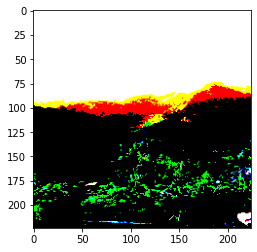

In [ ]:
plt.imshow(preprocess_image("./gdrive/MyDrive/projet_DLIM/imgs/jpg/100000.jpg"))

In [ ]:
PATH_TO_RESOURCES = "."
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"
PATH_TO_IMGS = "imgs/jpg"

In [ ]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/$PATH_TO_IMGS/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./gdrive/MyDrive/projet_DLIM//imgs/jpg/100000.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100001.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100002.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100100.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100101.jpg'])

In [ ]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['100000', '100001', '100002', '100100', '100101'])

In [ ]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
imgid_to_index

{'100000': 0,
 '100001': 1,
 '100002': 2,
 '100100': 3,
 '100101': 4,
 '100200': 5,
 '100201': 6,
 '100300': 7,
 '100301': 8,
 '100302': 9,
 '100400': 10,
 '100401': 11,
 '100500': 12,
 '100501': 13,
 '100502': 14,
 '100503': 15,
 '100600': 16,
 '100601': 17,
 '100700': 18,
 '100701': 19,
 '100800': 20,
 '100801': 21,
 '100900': 22,
 '100901': 23,
 '100902': 24,
 '101000': 25,
 '101001': 26,
 '101100': 27,
 '101101': 28,
 '101200': 29,
 '101201': 30,
 '101300': 31,
 '101301': 32,
 '101400': 33,
 '101401': 34,
 '101402': 35,
 '101403': 36,
 '101404': 37,
 '101500': 38,
 '101501': 39,
 '101502': 40,
 '101503': 41,
 '101504': 42,
 '101600': 43,
 '101601': 44,
 '101700': 45,
 '101701': 46,
 '101702': 47,
 '101800': 48,
 '101801': 49,
 '101900': 50,
 '101901': 51,
 '102000': 52,
 '102001': 53,
 '102100': 54,
 '102101': 55,
 '102200': 56,
 '102201': 57,
 '102202': 58,
 '102300': 59,
 '102301': 60,
 '102302': 61,
 '102303': 62,
 '102400': 63,
 '102401': 64,
 '102402': 65,
 '102500': 66,
 '102

## Network resnet

On utilise ResNet50

In [ ]:
ResNet = resnet.ResNet50(
    weights="imagenet", include_top=False,  input_shape=target_shape + (3,), pooling="avg"
)
ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Resnet Feature Extraction Network

On flatten juste la dernière couche de ResNet50 et on peut obtenir un embedding à partir de "resnet_feature_extractor"

In [ ]:
output = layers.Flatten()(ResNet.output)
resnet_feature_extractor = Model(ResNet.input, output, name="Embedding")
resnet_feature_extractor.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

## Embedding

On calcule les embeddings pour toutes les images

In [ ]:
ref = []
for path in IMG_NAMES_FULL:
  tmp_img = preprocess_image(path)
  ref.append(tmp_img)

In [ ]:
ref = np.array(ref)

In [ ]:
ref.shape

(1491, 224, 224, 3)

On calcule les embedding de nos images du train set (les vecteurs qui représentes les images: nos features)

In [ ]:
ref_embedding = resnet_feature_extractor(ref)

In [ ]:
ref_embedding.shape

TensorShape([1491, 2048])

In [ ]:
ref_embedding = np.array(ref_embedding)

In [ ]:
embedding = np.copy(ref_embedding)

### Kmeans et KNN (+ tests PCA) : ça n'a aucun sens de faire ça.

  Pour PCA il faut centrer les données

In [ ]:
train_mean = np.mean(ref_embedding)
embedding = embedding# - train_mean

In [ ]:
embedding.shape

(1491, 2048)

#### PCA

In [ ]:
# compute PCA matrix and keep only 64 dimensions
train_cov = np.dot(embedding.T, embedding)
eigvals, eigvecs = np.linalg.eig(train_cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
pca_transform = eigvecs[:, perm[2048 - 128:2048]]   # eigenvectors for the 64 last eigenvalues
pca_transform.shape, pca_transform.dtype

NameError: ignored

In [ ]:
embedding = np.dot(embedding, pca_transform)
embedding.shape

NameError: ignored

???????? Quand on utilise la PCA les valeurs sont des nombres imaginaires, pas trop cherché à savoir pourquoi

In [ ]:
embedding = np.abs(embedding)

#### Codebook

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

1 cluster pour 1 query (il y en a 512 dans le data set d'INRIA donc 512 centres)

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=512, random_state=0).fit(embedding)

In [ ]:
kmeans.cluster_centers_.shape

(512, 2048)

In [ ]:
global_descr = np.zeros((len(IMG_IDS), 2048), dtype=np.float32)

for ii, imgid in enumerate(IMG_IDS):
  #On centre, ou pas (si PCA il faut centrer)
  tmp = np.array([ref_embedding[ii]])# - train_mean
  #tmp = np.dot(tmp, pca_transform)
  #tmp = np.abs(tmp)
  prediction_id = kmeans.predict(tmp)
  print(prediction_id)
  prediction = kmeans.cluster_centers_[prediction_id]
  #Dans notre cas ça ne sert à rien de faire un histo comme dans le TP ou projet de MLRF
  #descr_hist = np.bincount(prediction, minlength=2048) / len(prediction)
  #global_descr[ii] = descr_hist
  global_descr[ii] = prediction
print("Indexing complete.")
global_descr.shape, global_descr.dtype

In [ ]:
search_engine = NearestNeighbors()

In [ ]:
search_engine.fit(global_descr)

NearestNeighbors()

#### Evaluation

In [ ]:
#EVALUATION
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "gt_student.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

In [ ]:
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
query_vectors = global_descr[query_imnos]


In [ ]:
distances, results = search_engine.kneighbors(query_vectors, 9)

In [ ]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += recall_step * precision_0 + (recall_step * (precision_1 - precision_0)) / 2 # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 90314, AP = 0.125
query 90376, AP = 1.000
query 90175, AP = 0.000
query 90949, AP = 0.083
query 90818, AP = 0.000
query 91374, AP = 0.528
query 90696, AP = 0.000
query 90464, AP = 1.000
query 90413, AP = 1.000
query 90356, AP = 0.500
query 90185, AP = 1.000
query 90284, AP = 0.000
query 90341, AP = 0.000
query 90783, AP = 0.100
query 90529, AP = 0.750
query 90721, AP = 0.750
query 91298, AP = 1.000
query 91437, AP = 0.031
query 90153, AP = 0.250
query 90581, AP = 0.000
query 90439, AP = 0.000
query 90841, AP = 0.000
query 91069, AP = 0.500
query 90766, AP = 0.528
query 90359, AP = 0.000
query 90081, AP = 0.250
query 90126, AP = 0.000
query 90531, AP = 0.000
query 90503, AP = 0.500
query 90093, AP = 0.000
query 90222, AP = 0.500
query 90977, AP = 0.062
query 90180, AP = 0.000
query 91246, AP = 0.500
query 90690, AP = 0.000
query 90669, AP = 0.278
query 90173, AP = 1.000
query 90484, AP = 0.000
query 91464, AP = 0.167
query 90631, AP = 0.050
query 91241, AP = 0.500
query 90041, AP 

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 8   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread(os.path.join(PATH_TO_RESOURCES, "thumbs", "%s.jpg" % IMG_IDS[imno]))
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(16,10))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

<Figure size 432x288 with 0 Axes>

### Méthode sans codebook, simplement KNN mAP de 0.737

In [ ]:
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "INRIA_HOLYDAYS.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
len(query_imnos)

1491

On calcule nos features pour les requêtes

In [ ]:
query_vectors = resnet_feature_extractor(ref[query_imnos])
query_vectors = np.array(query_vectors)

In [ ]:
len(query_vectors)

1491

On utilise KNN (plus rapide)

In [ ]:
search_engine = NearestNeighbors()
search_engine.fit(ref_embedding)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
distances, results = search_engine.kneighbors(query_vectors, 9)

mAP du TP MLRF

In [ ]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += recall_step * precision_0 + (recall_step * (precision_1 - precision_0)) / 2 # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 100000, AP = 1.000
query 100001, AP = 0.708
query 100002, AP = 1.000
query 100100, AP = 1.000
query 100101, AP = 1.000
query 100200, AP = 0.125
query 100201, AP = 0.167
query 100300, AP = 0.183
query 100301, AP = 1.000
query 100302, AP = 1.000
query 100400, AP = 0.100
query 100401, AP = 1.000
query 100500, AP = 1.000
query 100501, AP = 1.000
query 100502, AP = 1.000
query 100503, AP = 1.000
query 100600, AP = 1.000
query 100601, AP = 1.000
query 100700, AP = 1.000
query 100701, AP = 1.000
query 100800, AP = 1.000
query 100801, AP = 1.000
query 100900, AP = 0.500
query 100901, AP = 0.000
query 100902, AP = 0.598
query 101000, AP = 1.000
query 101001, AP = 1.000
query 101100, AP = 1.000
query 101101, AP = 1.000
query 101200, AP = 1.000
query 101201, AP = 1.000
query 101300, AP = 0.000
query 101301, AP = 0.000
query 101400, AP = 0.884
query 101401, AP = 1.000
query 101402, AP = 1.000
query 101403, AP = 0.884
query 101404, AP = 0.835
query 101500, AP = 1.000
query 101501, AP = 1.000


<Figure size 432x288 with 0 Axes>

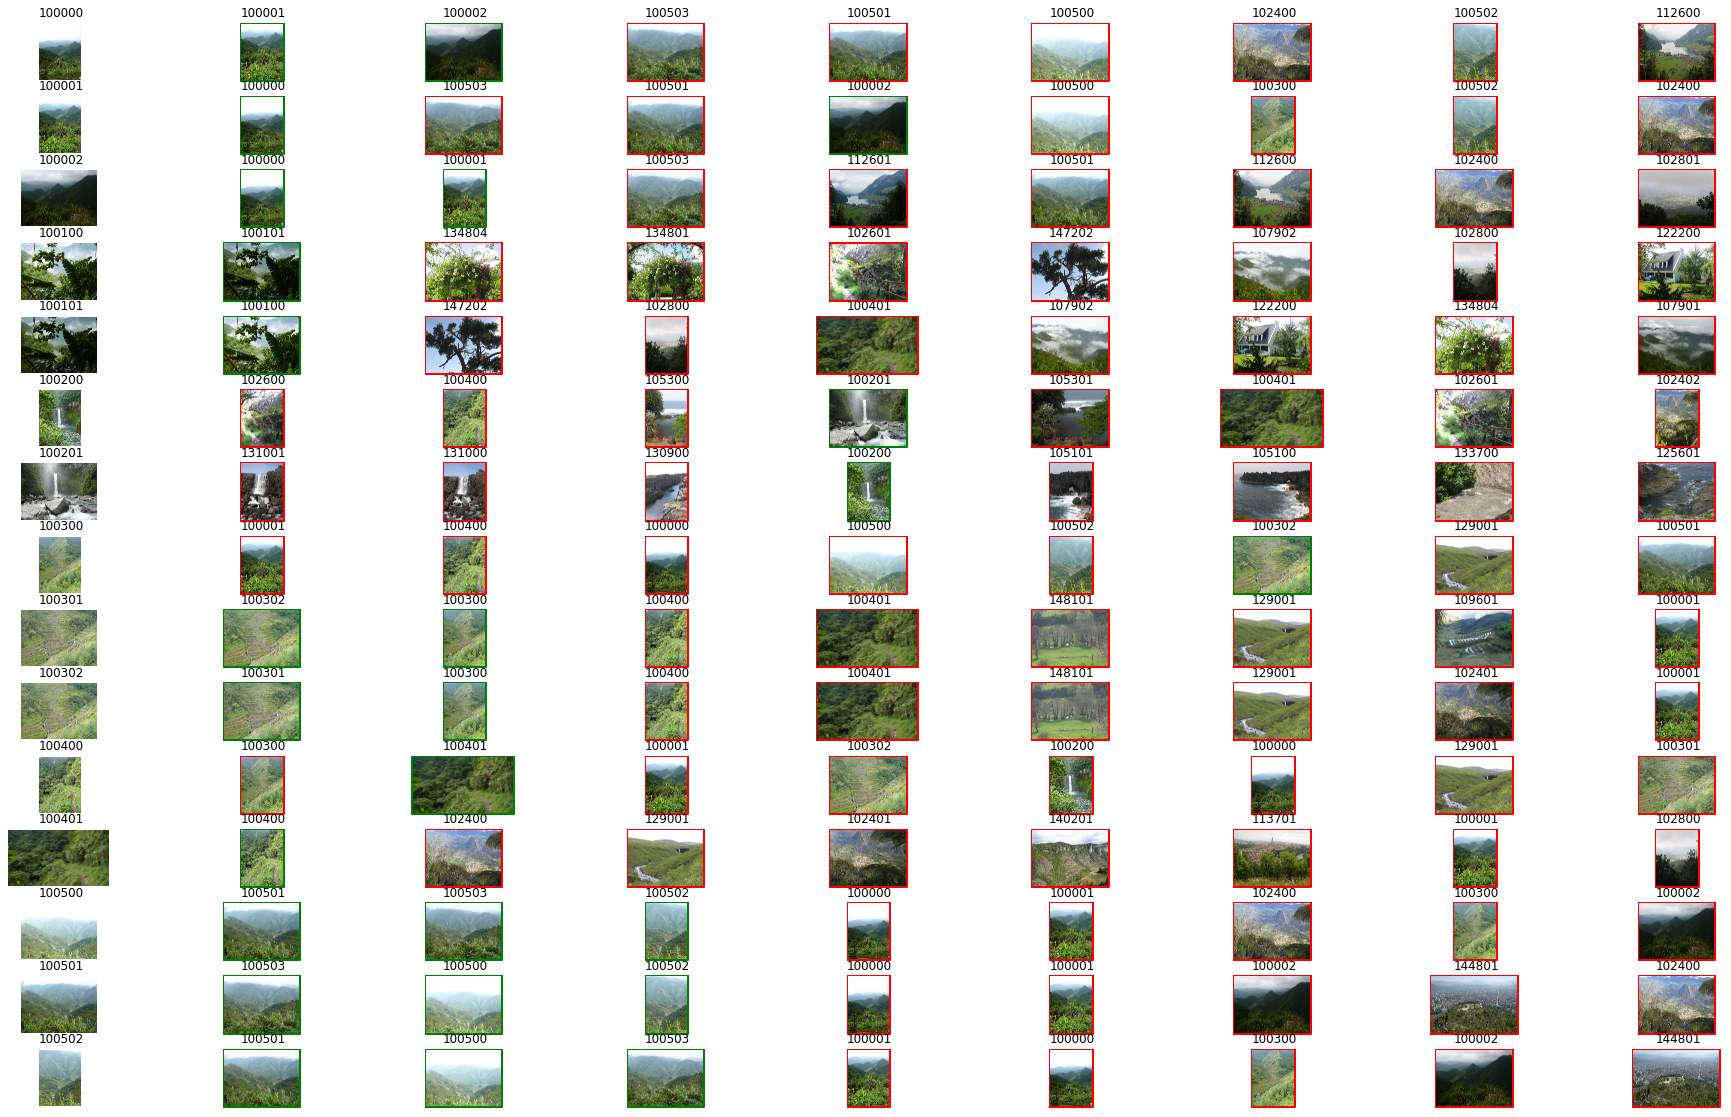

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 15   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread((os.path.join(PATH_TO_RESOURCES, PATH_TO_IMGS)) + "/%s.jpg" % IMG_IDS[imno])
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(32,20))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

## Triplet Loss tuto Keras adapté pour INRIA (le réseau d'embedding diffère).

In [ ]:
PATH_TO_IMGS = "imgs/jpg"

On load la GT complète

In [ ]:
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "INRIA_HOLYDAYS.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

In [ ]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/$PATH_TO_IMGS/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./gdrive/MyDrive/projet_DLIM//imgs/jpg/100000.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100001.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100002.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100100.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100101.jpg'])

In [ ]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['100000', '100001', '100002', '100100', '100101'])

In [ ]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
imgid_to_index

{'100000': 0,
 '100001': 1,
 '100002': 2,
 '100100': 3,
 '100101': 4,
 '100200': 5,
 '100201': 6,
 '100300': 7,
 '100301': 8,
 '100302': 9,
 '100400': 10,
 '100401': 11,
 '100500': 12,
 '100501': 13,
 '100502': 14,
 '100503': 15,
 '100600': 16,
 '100601': 17,
 '100700': 18,
 '100701': 19,
 '100800': 20,
 '100801': 21,
 '100900': 22,
 '100901': 23,
 '100902': 24,
 '101000': 25,
 '101001': 26,
 '101100': 27,
 '101101': 28,
 '101200': 29,
 '101201': 30,
 '101300': 31,
 '101301': 32,
 '101400': 33,
 '101401': 34,
 '101402': 35,
 '101403': 36,
 '101404': 37,
 '101500': 38,
 '101501': 39,
 '101502': 40,
 '101503': 41,
 '101504': 42,
 '101600': 43,
 '101601': 44,
 '101700': 45,
 '101701': 46,
 '101702': 47,
 '101800': 48,
 '101801': 49,
 '101900': 50,
 '101901': 51,
 '102000': 52,
 '102001': 53,
 '102100': 54,
 '102101': 55,
 '102200': 56,
 '102201': 57,
 '102202': 58,
 '102300': 59,
 '102301': 60,
 '102302': 61,
 '102303': 62,
 '102400': 63,
 '102401': 64,
 '102402': 65,
 '102500': 66,
 '102

In [ ]:
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
len(query_imnos)

1491

In [ ]:
#anchor_path = [PATH_TO_RESOURCES + "/thumbs/" + str(imgid) + ".jpg" for imgid in list(gt_data.keys())]
#posi_path = [PATH_TO_RESOURCES + "/thumbs/" + str(posimgid[0]) + ".jpg" for posimgid in list(gt_data.values())]

On construit les listes pour les paths des anchors et des images positives. Dans notre GT nous avons les combinaisons pour les 1491 images. On peut choisir de construre les paires anchor/positive pour les 1491 images ou seulement pour les 500 requêtes. On aura donc (991,991) ou (4144,4144)

In [ ]:
tmp = []

In [ ]:
anchor_path = []
posi_path = []

In [ ]:
values = list(gt_data.values())

In [ ]:
for ii, imgid in enumerate(list(gt_data.keys())):
  for posi in values[ii]:
    anchor_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(imgid) + ".jpg")
    posi_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(posi) + ".jpg")

In [ ]:
len(anchor_path), len(posi_path)

(4144, 4144)

In [ ]:
image_count = len(anchor_path)

In [ ]:
target_shape = (224, 224)

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

Pour construire les embeddings des requêtes avec le preprocess pour resnet.

In [ ]:
def preprocess_image_for_embedding(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image = tf.keras.utils.load_img(filename)
    image = image.convert('RGB')
    image = image.resize((target_shape))
    x = np.array(image)
    x = preprocess_input(x)
    return x

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_path)
positive_dataset = tf.data.Dataset.from_tensor_slices(posi_path)

In [ ]:
# On shuffle avec la même seed pour garder la cohérence des paires.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_path)
rng.shuffle(posi_path)

# Concat
negative_images = anchor_path + posi_path
np.random.RandomState(seed=32).shuffle(negative_images)

# On construit les négatives à partir de la concaténation des ancres et des images positives et on shuffle

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size= image_count * 2)

# Le dataset avec les triplets
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=image_count)
dataset = dataset.map(preprocess_triplets)

# Train et validation set
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

Resnet avec un pooling avg juste avant de flatten. On freeze tout sauf la fin de resnet.

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling="avg"
)
# On test différentes combinaisons: 0, 1, 2 ou 3 couches denses, pooling avg, max ou sans...
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(2048, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(2048, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(2048)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

# Idem ici, on peut tester de freeze plus ou moins de couches
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [ ]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                            

In [ ]:
#siamese_model.fit(train_dataset, epochs=1, validation_data=val_dataset)
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
104/104 [==============================] - ETA: 0s - loss: 0.2059

104/104 [==============================] - 212s 2s/step - loss: 0.2059 - val_loss: 0.1497
Epoch 2/5
104/104 [==============================] - ETA: 0s - loss: 0.1656

104/104 [==============================] - 200s 2s/step - loss: 0.1656 - val_loss: 0.1213
Epoch 3/5
104/104 [==============================] - ETA: 0s - loss: 0.1334

104/104 [==============================] - 200s 2s/step - loss: 0.1334 - val_loss: 0.1345
Epoch 4/5
104/104 [==============================] - ETA: 0s - loss: 0.1330

104/104 [==============================] - 199s 2s/step - loss: 0.1330 - val_loss: 0.1223
Epoch 5/5
104/104 [==============================] - ETA: 0s - loss: 0.1081

104/104 [==============================] - 200s 2s/step - loss: 0.1081 - val_loss: 0.0854


In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Voyons ce que donne la cosine similarity:

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99891686
Negative similarity 0.9967617


Un peu long a calculer mais il n'y a besoin de le faire qu'une fois.

In [ ]:
ref = []
# for path in anchor_path:
for path in IMG_NAMES_FULL:
  tmp_img = preprocess_image_for_embedding(path)
  ref.append(tmp_img)
ref = np.array(ref)

In [ ]:
ref.shape

(1491, 224, 224, 3)

In [ ]:
ref_embedding = embedding(ref)

In [ ]:
ref_embedding = np.array(ref_embedding)

On a donc les embeddings (vecteurs) de toutes les images.

In [ ]:
search_engine = NearestNeighbors()
search_engine.fit(ref_embedding)

NearestNeighbors()

On recupère les embeddings des requêtes et on cherche les 9 plus proches embeddings avec KNN car on veut les 8 plus proches voisins de la requête (donc 9 - le vecteur qui correspond à la requête = 8)

In [ ]:
query_vectors = embedding(ref[query_imnos])
query_vectors = np.array(query_vectors)
distances, results = search_engine.kneighbors(query_vectors, 9)

Code du TP de MLRF pour la mAP

In [ ]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += recall_step * precision_0 + (recall_step * (precision_1 - precision_0)) / 2 # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 100000, AP = 0.708
query 100001, AP = 0.708
query 100002, AP = 1.000
query 100100, AP = 1.000
query 100101, AP = 1.000
query 100200, AP = 0.000
query 100201, AP = 0.167
query 100300, AP = 0.148
query 100301, AP = 1.000
query 100302, AP = 1.000
query 100400, AP = 0.125
query 100401, AP = 0.000
query 100500, AP = 1.000
query 100501, AP = 1.000
query 100502, AP = 1.000
query 100503, AP = 0.817
query 100600, AP = 1.000
query 100601, AP = 1.000
query 100700, AP = 0.250
query 100701, AP = 1.000
query 100800, AP = 1.000
query 100801, AP = 1.000
query 100900, AP = 0.500
query 100901, AP = 0.000
query 100902, AP = 0.500
query 101000, AP = 1.000
query 101001, AP = 1.000
query 101100, AP = 1.000
query 101101, AP = 1.000
query 101200, AP = 1.000
query 101201, AP = 1.000
query 101300, AP = 0.000
query 101301, AP = 0.000
query 101400, AP = 0.866
query 101401, AP = 1.000
query 101402, AP = 1.000
query 101403, AP = 0.500
query 101404, AP = 0.299
query 101500, AP = 0.750
query 101501, AP = 0.677


<Figure size 432x288 with 0 Axes>

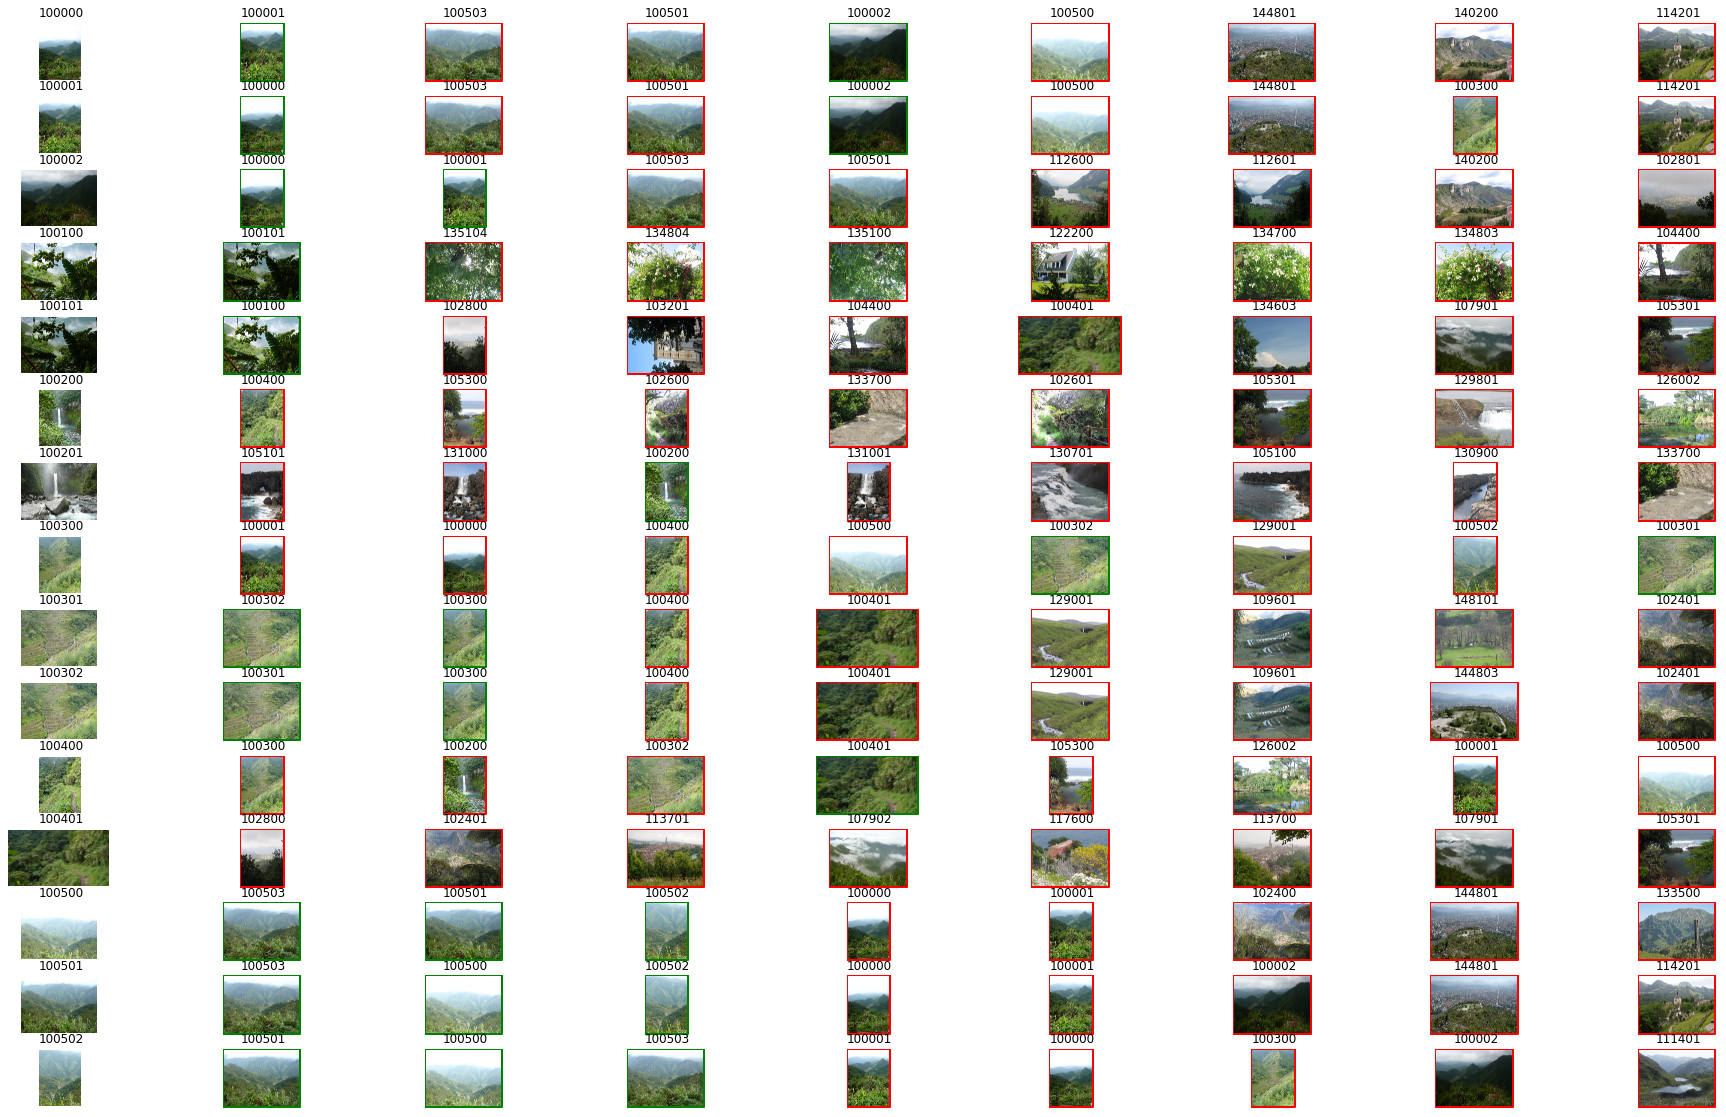

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 15   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread((os.path.join(PATH_TO_RESOURCES, PATH_TO_IMGS)) + "/%s.jpg" % IMG_IDS[imno])
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(32,20))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

## Siamese online mining https://omoindrot.github.io/triplet-loss

In [ ]:
PATH_TO_IMGS = "imgs/jpg"

In [ ]:
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "INRIA_HOLYDAYS.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

In [ ]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/$PATH_TO_IMGS/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./gdrive/MyDrive/projet_DLIM//imgs/jpg/100000.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100001.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100002.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100100.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100101.jpg'])

In [ ]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['100000', '100001', '100002', '100100', '100101'])

In [ ]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
imgid_to_index

{'100000': 0,
 '100001': 1,
 '100002': 2,
 '100100': 3,
 '100101': 4,
 '100200': 5,
 '100201': 6,
 '100300': 7,
 '100301': 8,
 '100302': 9,
 '100400': 10,
 '100401': 11,
 '100500': 12,
 '100501': 13,
 '100502': 14,
 '100503': 15,
 '100600': 16,
 '100601': 17,
 '100700': 18,
 '100701': 19,
 '100800': 20,
 '100801': 21,
 '100900': 22,
 '100901': 23,
 '100902': 24,
 '101000': 25,
 '101001': 26,
 '101100': 27,
 '101101': 28,
 '101200': 29,
 '101201': 30,
 '101300': 31,
 '101301': 32,
 '101400': 33,
 '101401': 34,
 '101402': 35,
 '101403': 36,
 '101404': 37,
 '101500': 38,
 '101501': 39,
 '101502': 40,
 '101503': 41,
 '101504': 42,
 '101600': 43,
 '101601': 44,
 '101700': 45,
 '101701': 46,
 '101702': 47,
 '101800': 48,
 '101801': 49,
 '101900': 50,
 '101901': 51,
 '102000': 52,
 '102001': 53,
 '102100': 54,
 '102101': 55,
 '102200': 56,
 '102201': 57,
 '102202': 58,
 '102300': 59,
 '102301': 60,
 '102302': 61,
 '102303': 62,
 '102400': 63,
 '102401': 64,
 '102402': 65,
 '102500': 66,
 '102

In [ ]:
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
len(query_imnos)

1491

In [ ]:
#anchor_path = [PATH_TO_RESOURCES + "/thumbs/" + str(imgid) + ".jpg" for imgid in list(gt_data.keys())]
#posi_path = [PATH_TO_RESOURCES + "/thumbs/" + str(posimgid[0]) + ".jpg" for posimgid in list(gt_data.values())]

Dans cette partie le réseau à besoin des images et des labels associés

In [ ]:
tmp = []

In [ ]:
anchor_path = []
labels = []

In [ ]:
values = list(gt_data.values())

In [ ]:
for ii, imgid in enumerate(list(gt_data.keys())):
  if (imgid in tmp):
    continue
  tmp.append(imgid)
  labels.append(ii)
  anchor_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(imgid) + ".jpg")
  for posi in values[ii]:
    anchor_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(posi) + ".jpg")
    tmp.append(posi)
    labels.append(ii)

On a donc toutes les images avec le label associé

In [ ]:
len(anchor_path), len(labels)

(1491, 1491)

In [ ]:
image_count = len(anchor_path)

In [ ]:
target_shape = (224, 224)

def preprocess_image(filename, label):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return (image, label)

On construit un dataset (imgs, labels)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_path)
labels_set = tf.data.Dataset.from_tensor_slices(labels)

Il faut essayer de faire varier la taille du batch: on a beaucoup de classes et peu d'images par classe.

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, labels_set))

dataset = dataset.shuffle(buffer_size=image_count)
dataset = dataset.map(preprocess_image)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(64, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(64, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling="avg"
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(2048, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(2048, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(2048)(flatten)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 [==============================] - 1s 0us/step


Cette fois DistanceLayer renvoie toutes les distances et plus les distances (anchor/positive, anchor/neg) comme précédemment.

L'input est cette fois juste les embeddings des imgs du batch.

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, embeddings):
      dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
      square_norm = tf.linalg.diag_part(dot_product)
      distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
      distances = tf.maximum(distances, 0.0)
      return distances

input = layers.Input(name="anchor", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(input)),
)

siamese_network = Model(
    inputs=[input], outputs=distances
)

Nous nous sommes basé sur des fonctions de ce github pour les fonctions "utils" https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py

In [ ]:
def _get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

La structure est différente du réseau précédent pour fonctionner avec le nouveau calcul de loss mais rien de spécial

**Batch all**

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.4):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # On split les labels des images.
        imgs, labels = data
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.

        pairwise_dist = self.siamese_network(imgs)
        anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
        anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
        triplet_loss = anchor_positive_dist - anchor_negative_dist + self.margin
        mask = _get_triplet_mask(labels)
        mask = tf.cast(mask, tf.float32)
        triplet_loss = tf.multiply(mask, triplet_loss)
        triplet_loss = tf.maximum(triplet_loss, 0.0)

        # Count number of positive triplets (where triplet_loss > 0)
        valid_triplets = tf.cast(tf.greater(triplet_loss, 1e-16), tf.float32)
        num_positive_triplets = tf.reduce_sum(valid_triplets)
        num_valid_triplets = tf.reduce_sum(mask)

        # Get final mean triplet loss over the positive valid triplets
        triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)
        return triplet_loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

**Batch hard**

In [ ]:
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """

    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask

def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """

    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_not(labels_equal)

    return mask

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.4):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        imgs, labels = data
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        pairwise_dist = self.siamese_network(imgs)
        mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
        mask_anchor_positive = tf.cast(mask_anchor_positive, tf.float32)
        # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
        anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

        hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
        tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

        # For each anchor, get the hardest negative
        # First, we need to get a mask for every valid negative (they should have different labels)
        mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
        mask_anchor_negative =  tf.cast(mask_anchor_negative, tf.float32)
        # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
        max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

        hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
        tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + self.margin, 0.0)

        # Get final mean triplet loss
        # Ca ne change rien à la mAP finale de faire reduce_mean ou reduce_sum
        # triplet_loss = tf.reduce_sum(triplet_loss)
        triplet_loss = tf.reduce_mean(triplet_loss)
        return triplet_loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [ ]:
siamese_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 anchor (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 Embedding (Functional)      (None, 2048)              27784064  
                                                                 
 distance_layer (DistanceLay  (None, None)             0         
 er)                                                             
                                                                 
Total params: 27,784,064
Trainable params: 13,127,680
Non-tra

In [ ]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
19/19 [==============================] - 66s 1s/step - loss: 10.8432 - val_loss: 6.4851
Epoch 2/10
19/19 [==============================] - 28s 2s/step - loss: 11.1389 - val_loss: 11.2570
Epoch 3/10
19/19 [==============================] - 28s 2s/step - loss: 7.2097 - val_loss: 5.8399
Epoch 4/10
19/19 [==============================] - 28s 2s/step - loss: 7.7996 - val_loss: 5.9284
Epoch 5/10
19/19 [==============================] - 28s 2s/step - loss: 6.7498 - val_loss: 7.1584
Epoch 6/10
19/19 [==============================] - 28s 2s/step - loss: 7.1444 - val_loss: 4.5566
Epoch 7/10
19/19 [==============================] - 30s 2s/step - loss: 5.3042 - val_loss: 3.2411
Epoch 8/10
19/19 [==============================] - 29s 2s/step - loss: 5.1949 - val_loss: 5.2691
Epoch 9/10
19/19 [==============================] - 28s 2s/step - loss: 6.6705 - val_loss: 6.0925
Epoch 10/10
19/19 [==============================] - 29s 2s/step - loss: 6.1993 - val_loss: 6.1379


Pareil que tout à l'heure, on calcule les embeddings des images etc

In [ ]:
ref = []
for path in IMG_NAMES_FULL:
  tmp_img = preprocess_image_for_embedding(path)
  ref.append(tmp_img)
ref = np.array(ref)

In [ ]:
ref.shape

(1491, 224, 224, 3)

In [ ]:
ref_embedding = embedding(ref)

In [ ]:
ref_embedding = np.array(ref_embedding)

In [ ]:
search_engine = NearestNeighbors()
search_engine.fit(ref_embedding)

NearestNeighbors()

In [ ]:
query_vectors = embedding(ref[query_imnos])
query_vectors = np.array(query_vectors)
distances, results = search_engine.kneighbors(query_vectors, 9)

In [ ]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += recall_step * precision_0 + (recall_step * (precision_1 - precision_0)) / 2 # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 100000, AP = 0.792
query 100001, AP = 0.662
query 100002, AP = 0.662
query 100100, AP = 1.000
query 100101, AP = 1.000
query 100200, AP = 0.000
query 100201, AP = 0.062
query 100300, AP = 0.140
query 100301, AP = 1.000
query 100302, AP = 1.000
query 100400, AP = 0.250
query 100401, AP = 0.100
query 100500, AP = 1.000
query 100501, AP = 1.000
query 100502, AP = 1.000
query 100503, AP = 0.817
query 100600, AP = 1.000
query 100601, AP = 1.000
query 100700, AP = 1.000
query 100701, AP = 1.000
query 100800, AP = 1.000
query 100801, AP = 1.000
query 100900, AP = 0.500
query 100901, AP = 0.000
query 100902, AP = 0.500
query 101000, AP = 1.000
query 101001, AP = 1.000
query 101100, AP = 1.000
query 101101, AP = 1.000
query 101200, AP = 1.000
query 101201, AP = 1.000
query 101300, AP = 0.000
query 101301, AP = 0.000
query 101400, AP = 0.750
query 101401, AP = 1.000
query 101402, AP = 1.000
query 101403, AP = 0.944
query 101404, AP = 0.613
query 101500, AP = 1.000
query 101501, AP = 1.000


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 15   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread((os.path.join(PATH_TO_RESOURCES, PATH_TO_IMGS)) + "/%s.jpg" % IMG_IDS[imno])
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(32,20))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

<Figure size 432x288 with 0 Axes>

## Siamese avec data augmentation

In [ ]:
PATH_TO_IMGS = "imgs/jpg"

In [ ]:
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "INRIA_HOLYDAYS.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

In [ ]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/$PATH_TO_IMGS/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./gdrive/MyDrive/projet_DLIM//imgs/jpg/100000.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100001.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100002.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100100.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100101.jpg'])

In [ ]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['100000', '100001', '100002', '100100', '100101'])

In [ ]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
imgid_to_index

{'100000': 0,
 '100001': 1,
 '100002': 2,
 '100100': 3,
 '100101': 4,
 '100200': 5,
 '100201': 6,
 '100300': 7,
 '100301': 8,
 '100302': 9,
 '100400': 10,
 '100401': 11,
 '100500': 12,
 '100501': 13,
 '100502': 14,
 '100503': 15,
 '100600': 16,
 '100601': 17,
 '100700': 18,
 '100701': 19,
 '100800': 20,
 '100801': 21,
 '100900': 22,
 '100901': 23,
 '100902': 24,
 '101000': 25,
 '101001': 26,
 '101100': 27,
 '101101': 28,
 '101200': 29,
 '101201': 30,
 '101300': 31,
 '101301': 32,
 '101400': 33,
 '101401': 34,
 '101402': 35,
 '101403': 36,
 '101404': 37,
 '101500': 38,
 '101501': 39,
 '101502': 40,
 '101503': 41,
 '101504': 42,
 '101600': 43,
 '101601': 44,
 '101700': 45,
 '101701': 46,
 '101702': 47,
 '101800': 48,
 '101801': 49,
 '101900': 50,
 '101901': 51,
 '102000': 52,
 '102001': 53,
 '102100': 54,
 '102101': 55,
 '102200': 56,
 '102201': 57,
 '102202': 58,
 '102300': 59,
 '102301': 60,
 '102302': 61,
 '102303': 62,
 '102400': 63,
 '102401': 64,
 '102402': 65,
 '102500': 66,
 '102

In [ ]:
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
len(query_imnos)

1491

In [ ]:
#anchor_path = [PATH_TO_RESOURCES + "/thumbs/" + str(imgid) + ".jpg" for imgid in list(gt_data.keys())]
#posi_path = [PATH_TO_RESOURCES + "/thumbs/" + str(posimgid[0]) + ".jpg" for posimgid in list(gt_data.values())]

In [ ]:
tmp = []

In [ ]:
anchor_path = []
posi_path = []

In [ ]:
values = list(gt_data.values())

In [ ]:
for ii, imgid in enumerate(list(gt_data.keys())):
  if (imgid in tmp):
    continue
  tmp.append(imgid)
  for posi in values[ii]:
    anchor_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(imgid) + ".jpg")
    posi_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(posi) + ".jpg")
    tmp.append(posi)

In [ ]:
len(anchor_path), len(posi_path)

(991, 991)

In [ ]:
image_count = len(anchor_path)

In [ ]:
target_shape = (224, 224)


def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
)

Pour construire les embeddings des requêtes avec le preprocess pour resnet.

In [ ]:
def preprocess_image_for_embedding(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image = tf.keras.utils.load_img(filename)
    image = image.convert('RGB')
    image = image.resize((target_shape))
    x = np.array(image)
    x = preprocess_input(x)
    return x

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_path)
positive_dataset = tf.data.Dataset.from_tensor_slices(posi_path)

In [ ]:

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.

# On shuffle avec la même seed pour garder la cohérence des paires.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_path)
rng.shuffle(posi_path)

# Concat
negative_images = anchor_path + posi_path
np.random.RandomState(seed=32).shuffle(negative_images)

# On construit les négatives à partir de la concaténation des ancres et des images positives et on shuffle

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size= image_count * 2)

# Le dataset avec les triplets
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=image_count)
dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

Resnet avec un pooling avg juste avant de flatten. On freeze tout sauf la fin de resnet.

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False, pooling="avg"
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(2048, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(2048, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(2048)(flatten)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

On ajoute juste une layer de data augmentation. On peut tester de l'appliquer que sur l'ancre ou l'image positive ou les deux. Ca n'a pas vraiment de sens de le faire pour l'image négative. On pourrait observer l'impact individuel des différents traitements (RandromCrop, RandomFlip, RandomTranslation...) mais ça coute beaucoup d'unités...

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(160, 160),
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomTranslation(height_factor=(-0.5, 0.5), width_factor =(-0.5, 0,5)),
    tf.keras.layers.RandomRotation(factor=(-0.5, 0.5)),
    tf.keras.layers.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5)),
])
  

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(augment_layer(anchor_input))),
    embedding(resnet.preprocess_input(augment_layer(positive_input))),
    embedding(resnet.preprocess_input((negative_input))),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.4):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [ ]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['anchor[0][0]',                 
                                                                  'positive[0][0]']           

In [ ]:
#siamese_model.fit(train_dataset, epochs=1, validation_data=val_dataset)
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.1999

25/25 [==============================] - 62s 2s/step - loss: 0.1999 - val_loss: 0.1373
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.1001

25/25 [==============================] - 46s 2s/step - loss: 0.1001 - val_loss: 0.0696
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.0678

25/25 [==============================] - 45s 2s/step - loss: 0.0678 - val_loss: 0.0636
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.0701

25/25 [==============================] - 45s 2s/step - loss: 0.0701 - val_loss: 0.0288
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.0551

25/25 [==============================] - 45s 2s/step - loss: 0.0551 - val_loss: 0.0704
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 0.0539

25/25 [==============================] - 45s 2s/step - loss: 0.0539 - val_loss: 0.0427
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 0.0482

25/25 [==============================] - 46s 2s/step - loss: 0.0482 - val_loss: 0.0417
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 0.0285

25/25 [==============================] - 45s 2s/step - loss: 0.0285 - val_loss: 0.0317
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 0.0331

25/25 [==============================] - 45s 2s/step - loss: 0.0331 - val_loss: 0.0264
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 0.0343

25/25 [==============================] - 45s 2s/step - loss: 0.0343 - val_loss: 0.0323


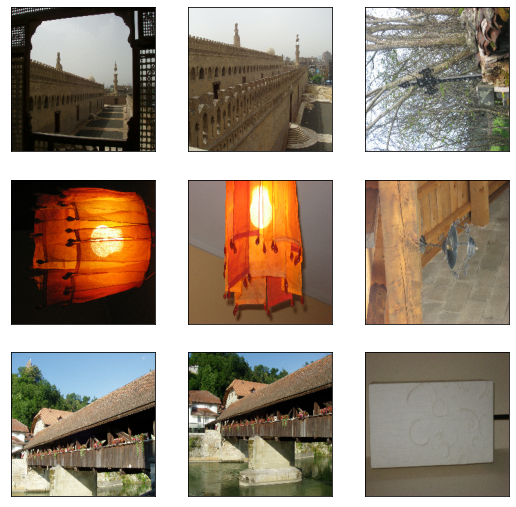

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Un peu long a calculer mais il n'y a besoin de le faire qu'une fois.

In [ ]:
ref = []
for path in IMG_NAMES_FULL:
  tmp_img = preprocess_image_for_embedding(path)
  ref.append(tmp_img)
ref = np.array(ref)

In [ ]:
ref.shape

(1491, 224, 224, 3)

In [ ]:
ref_embedding = embedding(ref)

In [ ]:
ref_embedding = np.array(ref_embedding)

On a donc les embeddings (vecteurs) de toutes les images.

In [ ]:
search_engine = NearestNeighbors()
search_engine.fit(ref_embedding)

NearestNeighbors()

On recupère les embeddings des requêtes et on cherche les 9 plus proches embeddings avec KNN car on veut les 8 plus proches voisins de la requête (donc 9 - le vecteur qui correspond à la requête = 8)

In [ ]:
query_vectors = embedding(ref[query_imnos])
query_vectors = np.array(query_vectors)
distances, results = search_engine.kneighbors(query_vectors, 9)

Code du TP pour la mAP

In [ ]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += recall_step * precision_0 + (recall_step * (precision_1 - precision_0)) / 2 # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 100000, AP = 1.000
query 100001, AP = 0.708
query 100002, AP = 1.000
query 100100, AP = 1.000
query 100101, AP = 1.000
query 100200, AP = 0.083
query 100201, AP = 0.167
query 100300, AP = 0.155
query 100301, AP = 1.000
query 100302, AP = 0.792
query 100400, AP = 1.000
query 100401, AP = 0.250
query 100500, AP = 1.000
query 100501, AP = 1.000
query 100502, AP = 1.000
query 100503, AP = 0.817
query 100600, AP = 1.000
query 100601, AP = 1.000
query 100700, AP = 1.000
query 100701, AP = 1.000
query 100800, AP = 1.000
query 100801, AP = 1.000
query 100900, AP = 0.500
query 100901, AP = 0.000
query 100902, AP = 0.500
query 101000, AP = 1.000
query 101001, AP = 1.000
query 101100, AP = 1.000
query 101101, AP = 1.000
query 101200, AP = 1.000
query 101201, AP = 1.000
query 101300, AP = 0.000
query 101301, AP = 0.000
query 101400, AP = 0.866
query 101401, AP = 1.000
query 101402, AP = 1.000
query 101403, AP = 0.884
query 101404, AP = 0.944
query 101500, AP = 0.750
query 101501, AP = 1.000


On enregistre le model

In [ ]:
embedding.save("./models/tripletloss")

On télécharge le model enregistré

In [ ]:
!zip -r tripletsloss models

  adding: models/ (stored 0%)
  adding: models/embeddings/ (stored 0%)
  adding: models/embeddings/keras_metadata.pb (deflated 96%)
  adding: models/embeddings/saved_model.pb (deflated 92%)
  adding: models/embeddings/assets/ (stored 0%)
  adding: models/embeddings/variables/ (stored 0%)
  adding: models/embeddings/variables/variables.index (deflated 81%)
  adding: models/embeddings/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 15   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread((os.path.join(PATH_TO_RESOURCES, PATH_TO_IMGS)) + "/%s.jpg" % IMG_IDS[imno])
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(32,20))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

# Create queries and train set from GT (utils)

In [ ]:
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"

In [ ]:
PATH_TO_IMGS = "imgs/jpg"

In [ ]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/$PATH_TO_IMGS/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./gdrive/MyDrive/projet_DLIM//imgs/jpg/100000.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100001.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100002.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100100.jpg',
  './gdrive/MyDrive/projet_DLIM//imgs/jpg/100101.jpg'])

In [ ]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['100000', '100001', '100002', '100100', '100101'])

In [ ]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
imgid_to_index

{'100000': 0,
 '100001': 1,
 '100002': 2,
 '100100': 3,
 '100101': 4,
 '100200': 5,
 '100201': 6,
 '100300': 7,
 '100301': 8,
 '100302': 9,
 '100400': 10,
 '100401': 11,
 '100500': 12,
 '100501': 13,
 '100502': 14,
 '100503': 15,
 '100600': 16,
 '100601': 17,
 '100700': 18,
 '100701': 19,
 '100800': 20,
 '100801': 21,
 '100900': 22,
 '100901': 23,
 '100902': 24,
 '101000': 25,
 '101001': 26,
 '101100': 27,
 '101101': 28,
 '101200': 29,
 '101201': 30,
 '101300': 31,
 '101301': 32,
 '101400': 33,
 '101401': 34,
 '101402': 35,
 '101403': 36,
 '101404': 37,
 '101500': 38,
 '101501': 39,
 '101502': 40,
 '101503': 41,
 '101504': 42,
 '101600': 43,
 '101601': 44,
 '101700': 45,
 '101701': 46,
 '101702': 47,
 '101800': 48,
 '101801': 49,
 '101900': 50,
 '101901': 51,
 '102000': 52,
 '102001': 53,
 '102100': 54,
 '102101': 55,
 '102200': 56,
 '102201': 57,
 '102202': 58,
 '102300': 59,
 '102301': 60,
 '102302': 61,
 '102303': 62,
 '102400': 63,
 '102401': 64,
 '102402': 65,
 '102500': 66,
 '102

In [ ]:
PATH_TO_RESOURCES = "./gdrive/MyDrive/projet_DLIM/"
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "INRIA_HOLYDAYS.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

In [ ]:
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [ ]:
def create_sets_from_gt(gt_data, nb_queries = 1):
  tmp = []
  values = list(gt_data.values())

  test_x_path = []
  test_y = []
  train_x_path = []
  train_y = []

  label = 0
  for ii, imgid in enumerate(list(gt_data.keys())):
    if (imgid in tmp):
      continue
    if (len(values[ii]) < nb_queries):
      print("err")
      continue
    tmp.append(imgid)
    test_y.append(label)
    test_x_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(imgid) + ".jpg")
    count = 1

    for posi in values[ii]:
      if (count < nb_queries):
        test_x_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(posi) + ".jpg")
        test_y.append(label)
        count = count + 1
      else:
        train_x_path.append(PATH_TO_RESOURCES + PATH_TO_IMGS + "/" + str(posi) + ".jpg")
        train_y.append(label)
      tmp.append(posi)
    label = label + 1

  return test_x_path, test_y, train_x_path, train_y

In [ ]:
test_x_path, test_y, train_x_path, train_y = create_sets_from_gt(gt_data, 1)

In [ ]:
len(test_x_path), len(train_x_path)

(500, 991)

In [ ]:
len(test_y), len(train_y)

(500, 991)